<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/Assignment_4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

XXX By Mesay

XXX By Zilal

XXX By Jianci

# **Reference**
https://campuswire.com/c/GB46E5679/feed/587

https://liangfgithub.github.io/Coding/F24_Coding4.pdf

# **Setting**

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# **Part I: Gaussian Mixtures**

reference:

https://liangfgithub.github.io/PSL/w7/w7_3_EM.html

https://campuswire.com/c/GB46E5679/feed/589 (hint)


In [3]:
#change with your path
path_to_data='/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/CA/'

In [4]:
data = pd.read_table('https://liangfgithub.github.io/Data/faithful.dat', sep="\s+", index_col=0)

Text(0, 0.5, 'Duration')

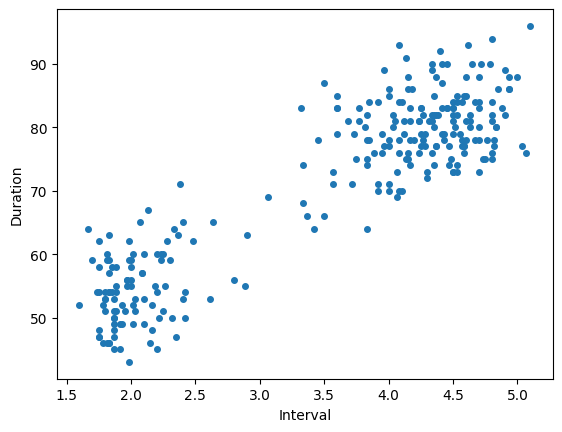

In [5]:
#data = pd.read_table(path_to_data+"faithful.dat", sep="\s+", index_col=0)
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Interval')
plt.ylabel('Duration')

In [6]:
data.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


In [7]:
#create a matrix for all sample sizes for G, the corresponding p, u
def create_s_mtrx(G,n,s_interval=10): #sample size interval is default to 10, not required by instruction, but will need to handle G >2 as required by the instruction
  #matrix of G/ aka Z
  G_mtrx = np.arange(1,G+1,1)
  #sample size by group
  s_mtrx = s_interval*2**(G_mtrx-1)

  cumsum_s_mtrx =  np.cumsum(s_mtrx, axis =0)
  cumsum_s_mtrx

  #anything above limit taking 0s
  G_mtrx[cumsum_s_mtrx > n] = 0
  s_mtrx[cumsum_s_mtrx > n] = 0
  cumsum_s_mtrx[cumsum_s_mtrx > n] = 0
  #print(cumsum_s_mtrx)

  #biggest possible matrix
  max_G = np.where(cumsum_s_mtrx>0)[0][-1]+2

  final_G = min(max_G,G)
  last_s_mtrx = n - sum(s_mtrx[0:final_G-1])
  s_mtrx[final_G-1]=last_s_mtrx
  try:
    s_mtrx[final_G:]=0
  except:
    pass

  G_mtrx_final = np.arange(1,final_G+1,1)
  s_mtrx_final = s_mtrx[0:final_G]


  # initialize matrix of p
  p_mtrx = s_mtrx_final /n

  #create a new dim in data to show the G assignment
  G_assignment = np.repeat(G_mtrx_final,s_mtrx_final)
  p_assignment = np.repeat(p_mtrx,s_mtrx_final)

  #data with g assignment
  data_wg = data.copy()
  data_wg['G'] = G_assignment
  data_wg['p'] = p_assignment

  # calculate U by group for the two dimenison
  # keep column names so it's easier to understand
  mean_df = data_wg.groupby('G').mean().transpose()
  #u_by_k.columns = [ 'G','eruptions_avg',	'waiting_avg']

  return   G_mtrx_final, s_mtrx_final, p_mtrx, final_G, data_wg, mean_df


In [8]:
#number of componants
G=3
#sample size
n=len(data)

G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df= create_s_mtrx(G,n,s_interval=10)

In [9]:
G_mtrx

array([1, 2, 3])

In [10]:
s_mtrx

array([ 10,  20, 242])

In [11]:
# https://liangfgithub.github.io/PSL/w7/w7_2_mixture.html
# Starting with an initial guess of our parameters, which encompass the means, variances, and mixing weight π of the Gaussians

p_mtrx

array([0.03676471, 0.07352941, 0.88970588])

In [12]:
data_wg

,eruptions,waiting,G,p
1,3.600,79,1,0.036765
2,1.800,54,1,0.036765
3,3.333,74,1,0.036765
4,2.283,62,1,0.036765
5,4.533,85,1,0.036765
...,...,...,...,...
268,4.117,81,3,0.889706
269,2.150,46,3,0.889706
270,4.417,90,3,0.889706
271,1.817,46,3,0.889706


In [13]:
data_mtrx = data[['eruptions','waiting']].to_numpy().reshape(-1,1)

In [14]:
#create a copy of data for QA purpose
data_wg_cal = data_wg.copy()

In [15]:
#get mean by G
mean_df

G,1,2,3
eruptions,3.303200,3.175000,3.521260
waiting,71.800000,68.250000,71.078512
p,0.036765,0.073529,0.889706


In [16]:
mean_temp = mean_df.iloc[0:G].T
mean_temp

,eruptions,waiting,p
G,,,
1,3.30320,71.800000,0.036765
2,3.17500,68.250000,0.073529
3,3.52126,71.078512,0.889706


In [17]:
p1 = mean_temp['p'].iloc[0]
p2 = mean_temp['p'].iloc[1]
try:
  p3 = mean_temp['p'].iloc[2]
except:
  print('no G = 3')

In [18]:
mean_temp['ug'] = [np.array(row) for row in mean_temp[['eruptions','waiting']].to_numpy()]
mean_temp

,eruptions,waiting,p,ug
G,,,,
1,3.30320,71.800000,0.036765,"[3.3032000000000004, 71.8]"
2,3.17500,68.250000,0.073529,"[3.175, 68.25]"
3,3.52126,71.078512,0.889706,"[3.5212603305785124, 71.07851239669421]"


In [19]:
mean_temp['ug'].to_numpy()

array([array([ 3.3032, 71.8   ]), array([ 3.175, 68.25 ]),
       array([ 3.52126033, 71.0785124 ])], dtype=object)

In [20]:
mean_mtrx_by_G = np.vstack(mean_temp['ug'].values)
mean_mtrx_by_G

array([[ 3.3032    , 71.8       ],
       [ 3.175     , 68.25      ],
       [ 3.52126033, 71.0785124 ]])

In [21]:
for i in range(0,final_G):
  print(mean_mtrx_by_G[i])

[ 3.3032 71.8   ]
[ 3.175 68.25 ]
[ 3.52126033 71.0785124 ]


In [22]:
mean_mtrx = np.array(mean_df)

In [23]:

data_erp = data_wg_cal['eruptions'].to_numpy().reshape(-1,1) - mean_mtrx[0]#average eruptions time
data_erp = pd.DataFrame(data_erp)
data_erp.columns= ['erp_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [24]:
data_erp

,erp_diff_1,erp_diff_2,erp_diff_3
0,0.2968,0.425,0.07874
1,-1.5032,-1.375,-1.72126
2,0.0298,0.158,-0.18826
3,-1.0202,-0.892,-1.23826
4,1.2298,1.358,1.01174
...,...,...,...
267,0.8138,0.942,0.59574
268,-1.1532,-1.025,-1.37126
269,1.1138,1.242,0.89574
270,-1.4862,-1.358,-1.70426


In [25]:
data_wait = data_wg_cal['waiting'].to_numpy().reshape(-1,1) -mean_mtrx[1]#average waiting time
data_wait = pd.DataFrame(data_wait)
data_wait.columns= ['wait_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [26]:
data_e_m = pd.DataFrame(mean_mtrx[0]).transpose()
data_e_m.columns= ['erp_'+ col for col in G_mtrx.astype('str').tolist()]

In [27]:
data_w_m = pd.DataFrame(mean_mtrx[1]).transpose()
data_w_m.columns= ['wait_'+ col for col in G_mtrx.astype('str').tolist()]

In [28]:
data_p = pd.DataFrame(mean_mtrx[2]).transpose()
data_p.columns= ['p_'+ col for col in G_mtrx.astype('str').tolist()]

In [29]:


data_wg_cal = data_wg_cal.merge(data_p, how='cross').merge(data_e_m,how='cross').merge(data_w_m,how='cross')
data_wg_cal = pd.concat([data_wg_cal,data_erp,data_wait],axis = 1)
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,p_3,erp_1,erp_2,erp_3,wait_1,wait_2,wait_3,erp_diff_1,erp_diff_2,erp_diff_3,wait_diff_1,wait_diff_2,wait_diff_3
0,3.600,79,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,0.2968,0.425,0.07874,7.2,10.75,7.921488
1,1.800,54,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,-1.5032,-1.375,-1.72126,-17.8,-14.25,-17.078512
2,3.333,74,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,0.0298,0.158,-0.18826,2.2,5.75,2.921488
3,2.283,62,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,-1.0202,-0.892,-1.23826,-9.8,-6.25,-9.078512
4,4.533,85,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,71.8,68.25,71.078512,1.2298,1.358,1.01174,13.2,16.75,13.921488


In [30]:
data_wg_cal['erp_mean']=np.repeat(mean_mtrx[0],s_mtrx)
data_wg_cal['erp_diff']=data_wg_cal['eruptions']-data_wg_cal['erp_mean']
data_wg_cal['wait_mean']=np.repeat(mean_mtrx[1],s_mtrx)
data_wg_cal['wait_diff']=data_wg_cal['waiting']-data_wg_cal['wait_mean']

In [31]:
data_wg_cal['xi']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]
data_wg_cal['u']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]
data_wg_cal['u_1']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_1','wait_1']].to_numpy()]
data_wg_cal['u_2']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_2','wait_2']].to_numpy()]
try:
  data_wg_cal['u_3']= [np.reshape(np.array(row),(2,1)) for row in data_wg_cal[['erp_3','wait_3']].to_numpy()]
except:
  print('no G = 3')

In [32]:
data_wg_cal

,eruptions,waiting,G,p,p_1,p_2,p_3,erp_1,erp_2,erp_3,...,wait_diff_3,erp_mean,erp_diff,wait_mean,wait_diff,xi,u,u_1,u_2,u_3
0,3.600,79,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,7.921488,3.30320,0.29680,71.800000,7.200000,"[[3.6], [79.0]]","[[3.3032000000000004], [71.8]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"
1,1.800,54,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-17.078512,3.30320,-1.50320,71.800000,-17.800000,"[[1.8], [54.0]]","[[3.3032000000000004], [71.8]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"
2,3.333,74,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,2.921488,3.30320,0.02980,71.800000,2.200000,"[[3.333], [74.0]]","[[3.3032000000000004], [71.8]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"
3,2.283,62,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-9.078512,3.30320,-1.02020,71.800000,-9.800000,"[[2.283], [62.0]]","[[3.3032000000000004], [71.8]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"
4,4.533,85,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,13.921488,3.30320,1.22980,71.800000,13.200000,"[[4.533], [85.0]]","[[3.3032000000000004], [71.8]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,4.117,81,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,9.921488,3.52126,0.59574,71.078512,9.921488,"[[4.117], [81.0]]","[[3.5212603305785124], [71.07851239669421]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"
268,2.150,46,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-25.078512,3.52126,-1.37126,71.078512,-25.078512,"[[2.15], [46.0]]","[[3.5212603305785124], [71.07851239669421]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"
269,4.417,90,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,18.921488,3.52126,0.89574,71.078512,18.921488,"[[4.417], [90.0]]","[[3.5212603305785124], [71.07851239669421]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"
270,1.817,46,3,0.889706,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,-25.078512,3.52126,-1.70426,71.078512,-25.078512,"[[1.817], [46.0]]","[[3.5212603305785124], [71.07851239669421]]","[[3.3032000000000004], [71.8]]","[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]"


In [33]:
data_wg_cal['xi_minus_u']= data_wg_cal['xi']-data_wg_cal['u']
data_wg_cal['xi_minus_u1']= data_wg_cal['xi']-data_wg_cal['u_1']
data_wg_cal['xi_minus_u2']= data_wg_cal['xi']-data_wg_cal['u_2']
try:
  data_wg_cal['xi_minus_u3']= data_wg_cal['xi']-data_wg_cal['u_3']
except:
  print('no G = 3')

In [34]:
data_wg_cal['xi_minus_u_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u']])
data_wg_cal['xi_minus_u1_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_1']])
data_wg_cal['xi_minus_u2_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_2']])
try:
  data_wg_cal['xi_minus_u3_T']= ([np.reshape(np.array(row),(1,2)) for row in data_wg_cal['xi']-data_wg_cal['u_3']])
except:
  print('no G = 3')

In [35]:
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,p_3,erp_1,erp_2,erp_3,...,u_2,u_3,xi_minus_u,xi_minus_u1,xi_minus_u2,xi_minus_u3,xi_minus_u_T,xi_minus_u1_T,xi_minus_u2_T,xi_minus_u3_T
0,3.600,79,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,"[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]","[[0.29679999999999973], [7.200000000000003]]","[[0.29679999999999973], [7.200000000000003]]","[[0.42500000000000027], [10.75]]","[[0.07873966942148769], [7.921487603305792]]","[[0.29679999999999973, 7.200000000000003]]","[[0.29679999999999973, 7.200000000000003]]","[[0.42500000000000027, 10.75]]","[[0.07873966942148769, 7.921487603305792]]"
1,1.800,54,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,"[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]","[[-1.5032000000000003], [-17.799999999999997]]","[[-1.5032000000000003], [-17.799999999999997]]","[[-1.3749999999999998], [-14.25]]","[[-1.7212603305785124], [-17.078512396694208]]","[[-1.5032000000000003, -17.799999999999997]]","[[-1.5032000000000003, -17.799999999999997]]","[[-1.3749999999999998, -14.25]]","[[-1.7212603305785124, -17.078512396694208]]"
2,3.333,74,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,"[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]","[[0.029799999999999827], [2.200000000000003]]","[[0.029799999999999827], [2.200000000000003]]","[[0.15800000000000036], [5.75]]","[[-0.1882603305785122], [2.921487603305792]]","[[0.029799999999999827, 2.200000000000003]]","[[0.029799999999999827, 2.200000000000003]]","[[0.15800000000000036, 5.75]]","[[-0.1882603305785122, 2.921487603305792]]"
3,2.283,62,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,"[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]","[[-1.0202000000000004], [-9.799999999999997]]","[[-1.0202000000000004], [-9.799999999999997]]","[[-0.8919999999999999], [-6.25]]","[[-1.2382603305785125], [-9.078512396694208]]","[[-1.0202000000000004, -9.799999999999997]]","[[-1.0202000000000004, -9.799999999999997]]","[[-0.8919999999999999, -6.25]]","[[-1.2382603305785125, -9.078512396694208]]"
4,4.533,85,1,0.036765,0.036765,0.073529,0.889706,3.3032,3.175,3.52126,...,"[[3.175], [68.25]]","[[3.5212603305785124], [71.07851239669421]]","[[1.2298], [13.200000000000003]]","[[1.2298], [13.200000000000003]]","[[1.3580000000000005], [16.75]]","[[1.011739669421488], [13.921487603305792]]","[[1.2298, 13.200000000000003]]","[[1.2298, 13.200000000000003]]","[[1.3580000000000005, 16.75]]","[[1.011739669421488, 13.921487603305792]]"


In [36]:

 #CA4,instruction p2, after 'Testing'
sigma = (data_wg_cal['xi_minus_u']*data_wg_cal['xi_minus_u_T']).sum(axis = 0)/n
sigma

array([[  1.28849554,  13.8662627 ],
       [ 13.8662627 , 183.56933185]])

In [37]:
# find determinant of sigma |sigma|
sigma_det = np.linalg.det(sigma)
sigma_det

44.25502506980155

In [38]:
data_wg_cal['sigma_inv'] =  [(sigma**-1)]*n

In [39]:
# the key term for prob density func pdf

data_wg_cal['pdf_1'] = -0.5*data_wg_cal['xi_minus_u1_T']*data_wg_cal['sigma_inv']*data_wg_cal['xi_minus_u1']
data_wg_cal['pdf_2'] = -0.5*data_wg_cal['xi_minus_u2_T']*data_wg_cal['sigma_inv']*data_wg_cal['xi_minus_u2']
try:
  data_wg_cal['pdf_3'] = -0.5*data_wg_cal['xi_minus_u3_T']*data_wg_cal['sigma_inv']*data_wg_cal['xi_minus_u3']
except:
  print('no G==3')

In [52]:
np.array(data_wg_cal['xi_minus_u1_T'].to_list()) @ np.array(data_wg_cal['sigma_inv'].to_list()) @ np.array(data_wg_cal['xi_minus_u1'].to_list())

array([[[ 0.65899122]],

       [[ 7.33896679]],

       [[ 0.03651131]],

       [[ 2.77300654]],

       [[ 4.46437461]],

       [[ 2.69275258]],

       [[ 6.20763056]],

       [[ 1.5826229 ]],

       [[ 7.83769269]],

       [[ 3.79262399]],

       [[ 7.17809063]],

       [[ 2.18328982]],

       [[ 1.63555043]],

       [[10.778574  ]],

       [[ 4.45398149]],

       [[ 6.38237562]],

       [[ 4.590918  ]],

       [[ 5.18345982]],

       [[ 9.25111649]],

       [[ 1.96136268]],

       [[ 8.62023314]],

       [[10.778574  ]],

       [[ 0.35740519]],

       [[ 0.1813988 ]],

       [[ 1.59038067]],

       [[ 1.23116541]],

       [[ 6.16099207]],

       [[ 1.04042356]],

       [[ 0.9304288 ]],

       [[ 2.44633808]],

       [[ 0.95151238]],

       [[ 2.07134872]],

       [[ 0.13304137]],

       [[ 1.64280264]],

       [[ 0.41232226]],

       [[ 7.09275679]],

       [[ 9.61671323]],

       [[ 3.99192254]],

       [[ 5.2843468 ]],

       [[ 7.38853666]],



In [47]:
data_wg_cal['xi_minus_u1_T'] @ data_wg_cal['sigma_inv'] @ data_wg_cal['xi_minus_u1']

Exception: Dot product shape mismatch, (272,) vs (2, 2)

In [40]:
pdf_1_processed = p1*np.exp(np.array(data_wg_cal['pdf_1'].to_list()))/(((2*np.pi)**2)*sigma_det)**0.5
pdf_2_processed = p2*np.exp(np.array(data_wg_cal['pdf_2'].to_list()))/(((2*np.pi)**2)*sigma_det)**0.5
try:
  pdf_3_processed = p3*np.exp(np.array(data_wg_cal['pdf_3'].to_list()))/(((2*np.pi)**2)*sigma_det)**0.5
except:
  print('no G==3')

In [41]:
log_pdf_1_processed = np.log(pdf_1_processed)
log_pdf_2_processed = np.log(pdf_2_processed)
try:
  log_pdf_3_processed = np.log(pdf_3_processed)
except:
  print('no G==3')

In [42]:
pdf_1_processed.shape
# n * little sigma

(272, 2, 2)

In [43]:
pdf_1_processed[0]

array([[0.00085001, 0.00081434],
       [0.00081434, 0.00076374]])

E-Step
https://campuswire.com/c/GB46E5679/feed/589

In [44]:
if G==2:
  loglik = np.log(pdf_1_processed+pdf_2_processed).sum(axis=0)
else:
  loglik = np.log(pdf_1_processed+pdf_2_processed+pdf_3_processed).sum(axis=0)

loglik


array([[-1152.30511559, -1151.76285293],
       [-1151.76285293, -1151.75426783]])

In [45]:
#create (xi-uk)
A_i_1 = np.array(data_wg_cal[['erp_diff_1','wait_diff_1']]).T
A_i_2 = np.array(data_wg_cal[['erp_diff_2','wait_diff_2']]).T
try:
  A_i_3 = np.array(data_wg_cal[['erp_diff_3','wait_diff_3']]).T
except:
  print('no G = 3')

In [46]:
np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(p_1_array ))

NameError: name 'p_1_array' is not defined

In [ ]:
p_1_array = (np.array(data_wg_cal['pdf_1'].to_list()))

In [ ]:
data_wg_cal[['p_1']]*np.exp(-0.5*(data_wg_cal[['pdf_1']]))

In [ ]:
#create log term
# double check on the TA session @10/25/2024 with professor, and she allowed hard code G = 2 or 3
# the second half of the log term is the probability density function (pdf) for 2D normal distribution
# so this is basically calcating the sum of (probability * pdf), a.k.a: calculate the corresponding
# distribution of Zi

if G == 2:
  pdf_i = (np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(np.array(data_wg_cal[['pdf_1']])))
        +np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(np.array(data_wg_cal[['pdf_2']]))))/(((2*np.pi)**2)*sigma_det)**0.5
else:
  pdf_i = (np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(np.array(data_wg_cal[['pdf_1']])))
        +np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(np.array(data_wg_cal[['pdf_2']])))
        +np.array(data_wg_cal[['p_3']])*np.exp(-0.5*(np.array(data_wg_cal[['pdf_3']]))))/(((2*np.pi)**2)*sigma_det)**0.5

pdf_i.shape #(272, 272)

In [ ]:
# Derivation 1:
# compute the Marginal likelihood function
# A marginal likelihood function (also known as the evidence in Bayesian statistics) is a probability function that represents the likelihood of
# observing data under a specific model

loglik = np.log(np.sum(pdf_i,axis=1)).sum()
loglik



In [ ]:
# Derivation 2:
# compute the complete likelihood function
# The complete likelihood (or complete-data likelihood) refers to the likelihood function that considers
# both observed and unobserved (latent) data in a probabilistic model.


loglik_complete = np.log(pdf_i).sum()
loglik_complete

In [ ]:
pdf_i.shape

In [ ]:
# Derivation 3:
# create a matrix of weight, representing the weight of observation x1 assigned to Group G
# Darin's anwer on this post gives great explanation: https://campuswire.com/c/GB46E5679/feed/648

if G == 2:
  w_i_1 = np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(A_i_1.T @ np.linalg.inv(sigma) @ A_i_1))  / (np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(A_i_1.T @ np.linalg.inv(sigma) @ A_i_1))
        +np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(A_i_2.T @ np.linalg.inv(sigma) @ A_i_2)))
  w_i_2 = np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(A_i_2.T @ np.linalg.inv(sigma) @ A_i_2))  / (np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(A_i_1.T @ np.linalg.inv(sigma) @ A_i_1))
        +np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(A_i_2.T @ np.linalg.inv(sigma) @ A_i_2)))
else:
  w_i_1 = np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(A_i_1.T @ np.linalg.inv(sigma) @ A_i_1))  / (np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(A_i_1.T @ np.linalg.inv(sigma) @ A_i_1))
        +np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(A_i_2.T @ np.linalg.inv(sigma) @ A_i_2)) +np.array(data_wg_cal[['p_3']])*np.exp(-0.5*(A_i_3.T @ np.linalg.inv(sigma) @ A_i_3)))
  w_i_2 = np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(A_i_2.T @ np.linalg.inv(sigma) @ A_i_2))  / (np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(A_i_1.T @ np.linalg.inv(sigma) @ A_i_1))
        +np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(A_i_2.T @ np.linalg.inv(sigma) @ A_i_2)) +np.array(data_wg_cal[['p_3']])*np.exp(-0.5*(A_i_3.T @ np.linalg.inv(sigma) @ A_i_3)))
  w_i_3 = np.array(data_wg_cal[['p_3']])*np.exp(-0.5*(A_i_3.T @ np.linalg.inv(sigma) @ A_i_3))  / (np.array(data_wg_cal[['p_1']])*np.exp(-0.5*(A_i_1.T @ np.linalg.inv(sigma) @ A_i_1))
        +np.array(data_wg_cal[['p_2']])*np.exp(-0.5*(A_i_2.T @ np.linalg.inv(sigma) @ A_i_2)) +np.array(data_wg_cal[['p_3']])*np.exp(-0.5*(A_i_3.T @ np.linalg.inv(sigma) @ A_i_3)))


Estep function: This function should return an n-by-G matrix, where the (i, j)th entry represents the
conditional probability P(Zi = k | xi). Here i ranges from 1 to n and k ranges from 1 to G.


Mstep function: This function should return the updated parameters for the Gaussian mixture model.


loglik function: This function computes the log-likelihood of the data given the parameters.

myEM function (main function): Inside this function, you can call the Estep and Mstep functions. The
function should take the following inputs and return the estimated parameters and log-likelihood (via
the loglik function)

# **Part II: HMM**

Baum-Welch Algorihtm

Viterbi Algorihtm

# **================ CODE ARCHIVE ================================**

In [ ]:
# TEST PANDA WITH MATRIX
matrix_1 = pd.DataFrame([[1, 2], [3, 4]])

In [ ]:
matrix_1

In [ ]:
# TEST PANDA WITH MATRIX
matrix_2 = pd.DataFrame([[[1,2],[3, 4]], [[5, 6],[7,8]]])

In [ ]:
matrix_2

In [ ]:
matrix_3 = pd.DataFrame([[np.zeros((2,3))], [np.zeros((3,2))]])
matrix_3

In [ ]:
data_wg_cal.head()

In [ ]:
data_wg_cal['x_i']= [np.array(row) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]

In [ ]:
data_wg_cal['u_g']= [np.array(row) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]

In [ ]:
data_wg_cal

In [ ]:
data_wg_cal['x_i'] - data_wg_cal['u_g']

In [ ]:

#silly way to calculate sigma - result match
# [a,b] * [a,b].T is bascially a^2 +ab+ab+ b^2
#data_wg_cal[['eruptions_2',	'waiting_2']] = data_wg_cal[[	'eruptions',	'waiting']]**2
#data_wg_cal[['erp_mean_2',	'wait_mean_2']] = data_wg_cal[[	'erp_mean',	'wait_mean']]**2
#data_wg_cal['eruptions_erp_mean'] = data_wg_cal['eruptions']*data_wg_cal['erp_mean']
#data_wg_cal['waiting_wait_mean'] = data_wg_cal['waiting']*data_wg_cal['wait_mean']
data_wg_cal[['erp_diff_2',	'wait_diff_2']]  = data_wg_cal[[	'erp_diff',	'wait_diff']]**2
data_wg_cal['erp_wait_diff']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']
data_wg_cal['erp_wait_diff_again']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']

#CA4,instruction p2, after 'Testing'
sigma = np.array(data_wg_cal[['erp_diff_2','erp_wait_diff','erp_wait_diff_again','wait_diff_2']].mean()).reshape(2,2)
sigma

In [ ]:
#manually check the determinant function
#det(A)=ad−bc
sigma_det = sigma[0,0]*sigma[1,1]-sigma[0,1]*sigma[1,0]
sigma_det